In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
from brian2 import us, ms, second, nA, pA, defaultclock
from utils.plotting import plot_sample, plot_input_layer_with_membrane_potential, plot_hennequin_reservoir_raster, plot_currents_distributions
from utils.plotting import plot_hennequin_reservoir_raster_without_input
from utils.plotting import plot_sample_with_labels
from utils.modulator import AsynchronousDeltaModulator, modulate
from utils.channel import send, text_to_bits
from utils.reservoir import getTauCurrent
from spiking_radio_reservoir import setup_hennequin_connectivity, setup_generator, setup_input_layer, setup_reservoir_layer, init_network

In [2]:
np.random.seed(42)

# Spiking Radio Channel

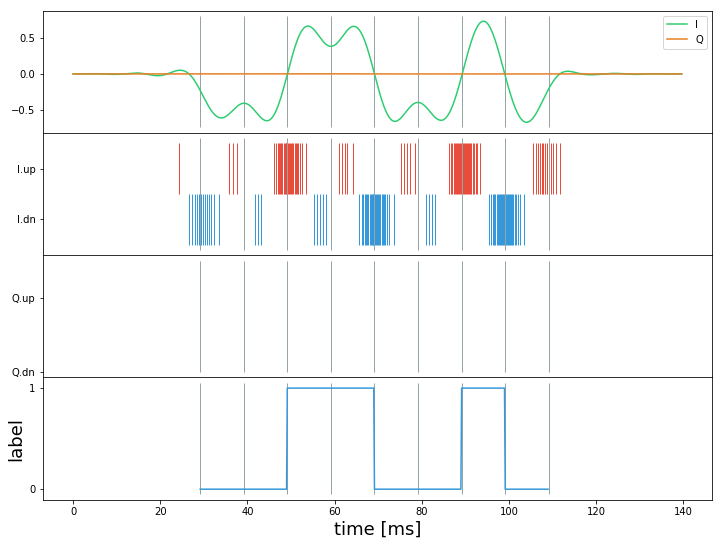

In [35]:
input_string = "2"
time_sample, sample, time_labels, labels, bins = send(input_string, m=2)
settings = {
    'thrup': 0.05,
    'thrdn': 0.05,
    'resampling_factor': 100,
    'stretch_factor': 10,
    'stop_after': 0.1,
    'stop_neuron': 4
}
modulators = [
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor']),
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor'])
]
indices, times, time_stim, signal = modulate(modulators[0], modulators[1], time_sample, sample, \
                                             resampling_factor=settings['resampling_factor'], stretch_factor=settings['stretch_factor'])
time_labels = time_labels*settings['stretch_factor']
bins = bins*settings['stretch_factor']*second
plot_sample_with_labels(signal, time_stim, indices, times, labels, time_labels, bins, figsize=(12, 9))

In [4]:
diff = np.diff(bins)
print("Average time length of a baseband symbol: {:.2f}ms".format(np.mean(diff)*1e3))

Average time length of a baseband symbol: 10.00ms


In [5]:
times = times*second
stop = round(bins[-1]/second, ndigits=3)+settings['stop_after']
duration = stop*second

## Reservoir

In [6]:
params = {
    'wGen': 500,
    'wInp': 500,
    'pIR': 0.07,
    'pE_local': 0.5,
    'pI_local': 1.0,
    'k': 3,
    'DoC': 0.2,
    'loc_wResE': 120,
    'scale_wResE': 20,
    'loc_wResI': -200,
    'scale_wResI': 40,
    'Ninp': 4,
    'N': 800,
    'Ngx': 20,
    'Ngy': 20
}
connectivity = setup_hennequin_connectivity(params['N'], params['pIR'], params['Ngx'], params['Ngy'], \
    params['pE_local'], params['pI_local'], params['k'], params['DoC'], \
    params['loc_wResE'], params['scale_wResE'], params['loc_wResI'], params['scale_wResI'])

In [7]:
num_syn = len(connectivity['res_res']['w'])
params['currents'] = {
    'gInp': {
        'Iahp': 0.5*pA,
        'Itau': getTauCurrent(5*ms),
        'Ispkthr': 0.2*nA
    },
    'gRes': {
        'Iahp': 0.5*pA,
        # 'Itauahp': getAhpTauCurrent(50*ms),
        'Itau': np.random.normal(loc=getTauCurrent(20*ms)/pA, scale=1, size=params['N'])*pA,
        'Ispkthr': 0.2*nA
    },
    'sInpRes': {
        'Ie_tau': getTauCurrent(7*ms)
    },
    'sResRes': {
        'Ie_tau': np.random.normal(loc=getTauCurrent(7*ms)/pA, scale=1, size=num_syn)*pA,
        'Ii_tau': np.random.normal(loc=getTauCurrent(7*ms)/pA, scale=1, size=num_syn)*pA,
    }
}

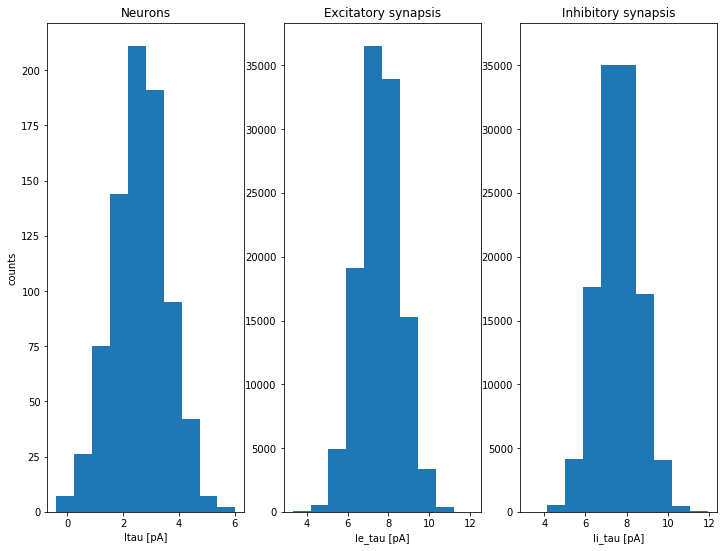

In [8]:
plot_currents_distributions(params['currents'])

In [9]:
components = {'generator': None, 'layers': {}, 'synapses': {}, 'monitors': {}}
components = setup_generator(components)
components = setup_input_layer(components, connectivity, params['Ninp'], params['currents'], params['wGen'])
components = setup_reservoir_layer(components, connectivity, params['N'], params['currents'], params['wInp'])
components['layers']['run_reg_gRes'] = components['layers']['gRes'].run_regularly("Imem=0*pA", dt=duration)
components['synapses']['run_reg_sResRes'] = components['synapses']['sResRes'].run_regularly("""
                                                                                                Ie_syn=Io_syn
                                                                                                Ii_syn=Io_syn
                                                                                            """, dt=duration)

In [10]:
network = init_network(components, indices, times)    
defaultclock.dt = 50*us
network.run(duration)

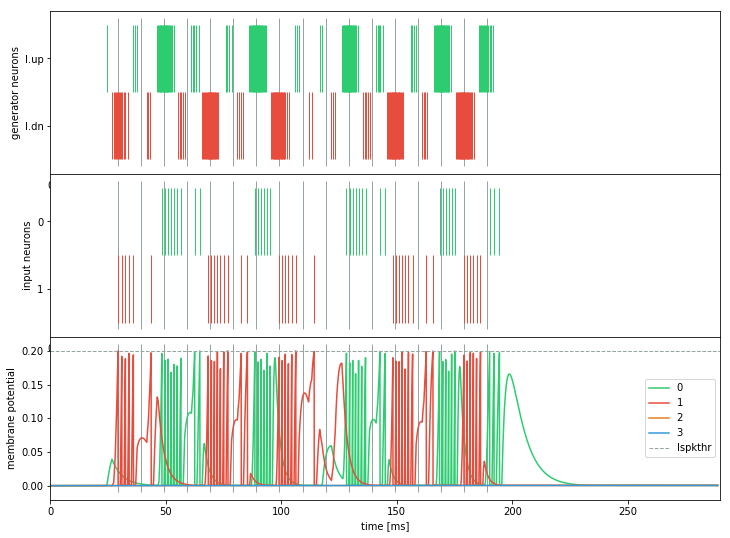

In [11]:
plot_input_layer_with_membrane_potential(indices, times, network, duration, bins=bins)

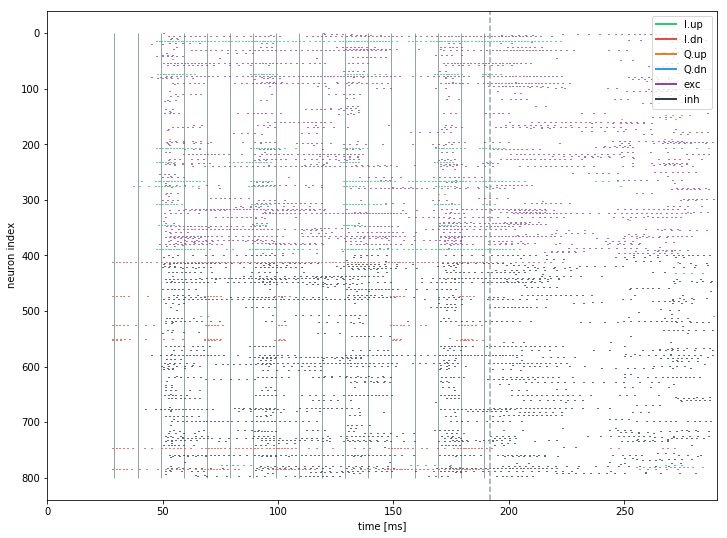

In [12]:
plot_hennequin_reservoir_raster(connectivity, params, network, times, duration, bins=bins)

# Readout

Let's readout the activity of the reservoir at the end of the stimulus, in order to find out if the reservoir is projecting the input patterns into different high-dimensional states. To do this we need to:
1. get the readout and filter out the neurons that receive input
2. bin it in some way
4. apply dimensionality reduction/clustering to extract a characteristic pattern of the binned readout

## Step 1.

In [13]:
input_neurons_Iup = connectivity['inp_res']['j'][connectivity['inp_res']['i']==0]
input_neurons_Idn = connectivity['inp_res']['j'][connectivity['inp_res']['i']==1]
input_neurons_Qup = connectivity['inp_res']['j'][connectivity['inp_res']['i']==2]
input_neurons_Qdn = connectivity['inp_res']['j'][connectivity['inp_res']['i']==3]
mask = np.zeros(params['N'])
mask[input_neurons_Iup] = 1.0
mask[input_neurons_Idn] = 1.0
mask[input_neurons_Qup] = 1.0
mask[input_neurons_Qdn] = 1.0
reservoir_neurons = np.ma.array(np.arange(params['N']), mask=mask)

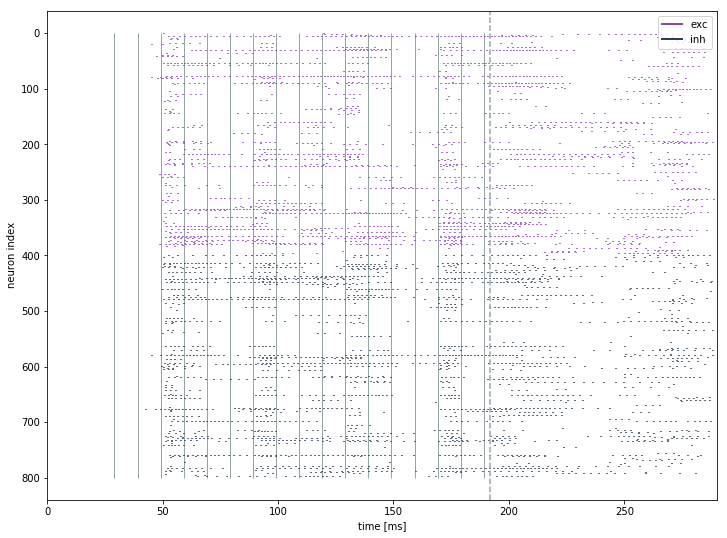

In [14]:
plot_hennequin_reservoir_raster_without_input(connectivity, params, network, times, duration, bins=bins)

In [15]:
input_neurons = np.concatenate([input_neurons_Iup, input_neurons_Idn, input_neurons_Qup, input_neurons_Qdn]) 

In [16]:
mask = np.zeros(len(network['mRes'].t), dtype=bool)
for n in input_neurons:
    idx = np.where(network['mRes'].i==n)[0]
    mask[idx] = True

## Step 2.

In [17]:
bin_size = 10*ms
ro, _, _ = np.histogram2d(network['mRes'].t[mask]/ms, network['mRes'].i[mask], \
                          bins=[int(duration/bin_size), params['N']], range=[[0, duration/ms], [0, params['N']]])

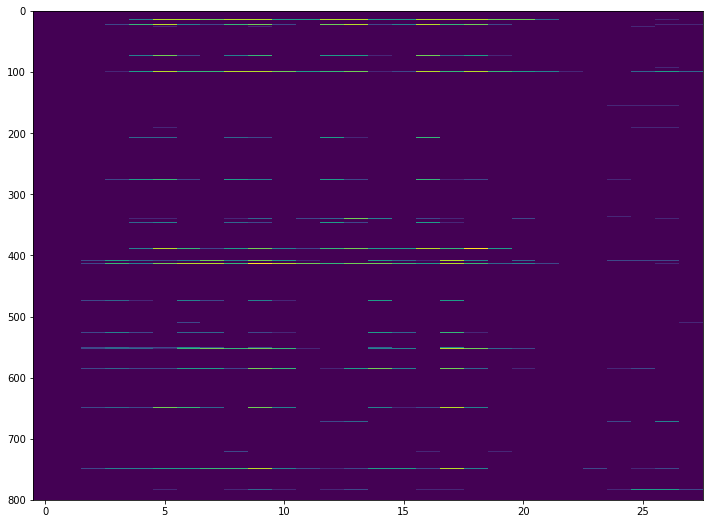

In [18]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.imshow(ro.T, origin='upper', interpolation='nearest', aspect='auto')